In [1]:
#------------------------------------------------------------------------------------------------------------------------------------------
# basic setup of the notebook
#------------------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import numba as nb
from numba import njit, prange
from numba.experimental import jitclass
import pickle
import sys
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import tomllib
from pip._vendor import tomli
import sys, os
from joblib import Parallel, delayed
import multiprocess as mp
from concurrent.futures import ProcessPoolExecutor
import scipy as sp
from scipy import *
import faulthandler
faulthandler.enable()
sys.path.append('../code')
from fit_drivers import *
from minimizer import *
from fit_functions import *
from output_functions import *
from general_stats import *
from jpac_colors import *
import fit_drivers, minimizer, fit_functions, output_functions, general_stats 


import math
import timeit
import time

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from iminuit import minimize
import time
from iminuit.util import describe
from typing import Annotated

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)
print("matplotlib version:", mpl.__version__)

from matplotlib import pyplot as plt

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

iminuit version: 2.28.0
matplotlib version: 3.9.2


In [2]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Importing fixed params for analysis
#------------------------------------------------------------------------------------------------------------------------------------------

with open('../ini_files/S_analysis_L24_pole.toml', "rb") as f:
    params = tomli.load(f)

with open('../ini_files/basic_setup_pole.toml', "rb") as f2:
    params2 = tomli.load(f2)

for i in params:
     params['{}'.format(i)].update(params2['{}'.format(i)])


who            = params['creator']['who']
  
  
path           = params['paths_to_files']['base_path']
mainpath       = '{}{}'.format(path,params['paths_to_files']['mainpath'])
resultspath    = '{}{}'.format(path,params['paths_to_files']['resultspath'])
resultsdir     = '{}{}'.format(path,params['paths_to_files']['resultsdir'])
plotsdir       = '{}{}'.format(path,params['paths_to_files']['plotsdir'])
Gcplotsdir     = '{}{}'.format(path,params['paths_to_files']['Gcplotsdir'])
sizelabel      = params['paths_to_files']['sizelabel']      
  
  
corrtype       = params['correlators']['corrtype']  
xi             = params['correlators']['xi']
beta           = params['correlators']['beta']
betanorm       = params['correlators']['betanorm']
Lextent        = params['correlators']['Lextent']
Textent        = params['correlators']['Textent']
size           = params['correlators']['size']
Ncfgs          = params['correlators']['Ncfgs']

als            = params['correlators']['als']
  
dini_Gc        = params['minimization_parameters']['dini_Gc']
dstop_Gc       = params['minimization_parameters']['dstop_Gc']
dmindata_Gc    = params['minimization_parameters']['dmindata_Gc']
dini_Vr        = params['minimization_parameters']['dini_Vr']
dstop_Vr       = params['minimization_parameters']['dstop_Vr']
dmindata_Vr    = params['minimization_parameters']['dmindata_Vr']
dfin_Gc        = params['minimization_parameters']['dfin_Gc']
dfin_Vr        = params['minimization_parameters']['dfin_Vr']
reuse          = params['minimization_parameters']['reuse']
inv_first      = params['minimization_parameters']['inv_first']
mcalls         = params['minimization_parameters']['mcalls']
mtol           = params['minimization_parameters']['mtol']
inipars_Gc     = params['minimization_parameters']['inipars_GC']
variants_Gc    = params['minimization_parameters']['variants_GC']
jackkl         = params['minimization_parameters']['jackkl']
xiini          = params['minimization_parameters']['xiini']
xifin          = params['minimization_parameters']['xifin']   
fileini        = params['minimization_parameters']['fileini']                         
filefin        = params['minimization_parameters']['filefin']
datatype_Gc    = params['minimization_parameters']['datatype_Gc']
model_Gc       = params['minimization_parameters']['model_Gc']
model_Vr       = params['minimization_parameters']['model_Vr']
datatype_Vr    = params['minimization_parameters']['datatype_Vr']
inipars_Vr     = params['minimization_parameters']['inipars_Vr']
variants_Vr    = params['minimization_parameters']['variants_Vr']
multiprocess   = params['minimization_parameters']['multiprocess']
cov_freeze     = params['minimization_parameters']['cov_freeze']
improve        = params['minimization_parameters']['improve']
multistart     = params['minimization_parameters']['multistart']
  

clean          = params['extra']['clean']
cutoff_ma      = params['extra']['cutoff_ma']
norm           = params['extra']['norm']
no_corrs       = params['extra']['no_corrs']
no_valid_check = params['extra']['no_valid_check']


gev_m1_tofm=5.068
als=np.array(als)/gev_m1_tofm

In [3]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Read raw data and prepare accordingly
#------------------------------------------------------------------------------------------------------------------------------------------
         

# Data used in the analysis
datam=[]
for k in range(len(xi)):
    dataint=[]
    for j in range(len(beta)):
        dataint.append(np.genfromtxt('../{}{}/L{}_b{}_xi{}_{}.dat'.format(mainpath,xi[k],int(sizelabel),beta[j],xi[k],corrtype)))
    datam.append(dataint)
    
# Collect completed configurations from raw data    
data=[]
for k in range(len(xi)):
    dataint=[]
    for j in range(len(datam[k])):
        if (len(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_S()))==0):
            dataint.append(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_W()))
        else:
            dataint.append(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_S()))
    data.append(dataint)

      

nconfigs=[]
for k in range(len(xi)):
    nint=[]
    for j in range(len(beta)):
        nint.append(int(len(data[k][j])/size[k]))
        print(int(len(data[k][j])/size[k]))
    nconfigs.append(nint)    

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
1557
1993
1958
1981
1978
1991
1997
1800
1977
1994
1781
1992
2000
2000
1700
1800
2000
2000
2000
2000
2000
2000
1700
1800
2000
1995
1987
1998
2000
2000
1699
1800


In [4]:
def mark_inset_mod(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

In [ ]:
xirun=xi[xiini:xifin+1]

k=3
r=5
pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001

mpl.rcParams['axes.autolimit_mode'] = 'data'
mpl.rcParams['axes.xmargin'] = 0.05
mpl.rcParams['axes.ymargin'] = 0.05

fig, ax = plt.subplots(figsize=(16,9))


bbox_axins=np.array([0.57,0.57,0.44,0.48])
axins = inset_axes(ax,width="100%",height="100%",loc='center',bbox_to_anchor=(bbox_axins),bbox_transform=ax.transAxes)
mark_inset_mod(ax, axins, loc1a=2, loc2a=3, loc1b=1, loc2b=4, fc="none", ec="0.6")


x_vals=[]
y_vals=[]
for x in range(len(xirun)):
    with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
        AIC_list = pickle.load(fp)

    xival=x+1
    totaltraj=int(len(data[x][k])/size[k])
    Nt=Textent

    Gc=np.zeros((int(totaltraj/jump_configs),Nt))
    for i in range(int(totaltraj/jump_configs)):
        index=jump_configs*i
        Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]


    gdata=jackknife(Gc,jackkl).sample()
    lt=len(Gc[0])
    dfin=min(lt,100)
    data_t   = np.linspace(1, lt, lt)
    data_2t  = np.linspace(1, 2*lt-1, 2*lt-1)
    if pos==0:
        data_y   = ensemble_stat(gdata).mean()
    else:
        data_y   = gdata[pos]
    data_cov = ensemble_stat(jackknife(gdata,jackkl).up()).rcov()
    data_err = np.sqrt(np.diagonal(ensemble_stat(jackknife(gdata,jackkl).up()).rcov()))


    data_covf = np.identity(lt)
    for i in range(len(np.sqrt(np.diag(data_cov)))):
        for j in range(len(np.sqrt(np.diag(data_cov)))):
            data_covf[i][j]*=np.sqrt(np.diag(data_cov))[i]*np.sqrt(np.diag(data_cov))[j]


    pars=np.array(AIC_list.selval()[0][1:])
    epars=np.array(AIC_list.selval()[1][1:])
    cpars=np.array(AIC_list.selval()[2][1:,1:])

    data_t_plot=np.linspace(data_t[0],data_t[-1],1000)

    tmin=AIC_list.ordered()[0][1]
    tmax=AIC_list.ordered()[0][2]

    bf_data_t=data_t[tmin-1:tmax-tmin+1]
    bf_data_y=data_y[tmin-1:tmax-tmin+1]
    bf_data_err=data_err[tmin-1:tmax-tmin+1]
    bf_data_t_plot=np.linspace(bf_data_t[0],bf_data_t[-1],1000)

    fit     = eval(model_Gc)(data_t_plot,*pars)
    efit    = prop_err(data_t_plot,model_Gc,pars,epars,cpars)
    fits    = eval(model_Gc)(bf_data_t_plot,*pars)
    efits   = prop_err(bf_data_t_plot,model_Gc,pars,epars,cpars)

    ax.set_yscale('log')
    ax.errorbar(data_t*als[x][k]/xival, data_y, data_err, fmt=markerlist[x], color=jpac_color_around[x],markerfacecolor='white', alpha=0.3)
    ax.errorbar(data_t*als[x][k]/xival, data_y, fmt=markerlist[x], color=jpac_color_around[x],markerfacecolor='white',markeredgecolor='none', alpha=1.)
    ax.errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[x], label='$\\xi={}$'.format(xirun[x]), color=jpac_color_around[x],markerfacecolor='white')
    ax.fill_between(data_t_plot*als[x][k]/xival, fit+efit, fit-efit,color=jpac_color_around[x],alpha=0.1)
    ax.fill_between(bf_data_t_plot*als[x][k]/xival, fits+efits, fits-efits,color=jpac_color_around[x],alpha=0.7)

    axins.errorbar(data_t*als[x][k]/xival, data_y, data_err, fmt=markerlist[k], color=jpac_color_around[x],markerfacecolor='white', alpha=0.3)
    axins.errorbar(data_t*als[x][k]/xival, data_y, fmt=markerlist[x], color=jpac_color_around[x],markerfacecolor='white',markeredgecolor='none', alpha=1.)
    axins.errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[x], color=jpac_color_around[x],markerfacecolor='white')
    axins.fill_between(data_t_plot*als[x][k]/xival, fit+efit, fit-efit,color=jpac_color_around[x],alpha=0.1)
    axins.fill_between(bf_data_t_plot*als[x][k]/xival, fits+efits, fits-efits,color=jpac_color_around[x],alpha=0.7)
    x_vals.append(data_t[0]*als[x][k]/xival)
    y_vals.append(data_y[0])

x_vals=np.array(x_vals)
y_vals=np.array(y_vals)

ax.set_yscale('log')
ax.autoscale(enable='True',axis='both')
ax.axis('tight')

if (ax.get_ylim()[0]<0.000001):
    ax.set_ylim(0.000001)
diffx=ax.get_xlim()[1]-ax.get_xlim()[0]
diffy=ax.get_ylim()[1]-ax.get_ylim()[0]
xini=ax.get_xlim()[0]+0.005*diffx
xfin=np.max(x_vals)+2*np.min(x_vals-xini)
yfin=(0.98)*ax.get_ylim()[1]
yminlog=np.min(np.log(y_vals))-1.*np.min(np.log(yfin)-np.log(y_vals))
yini=max(np.exp(yminlog),0.0001)
axins.set_yscale('log')
axins.set_xlim(xini,xfin)
axins.set_ylim(yini,yfin)
axins.xaxis.set_major_locator(ticker.MaxNLocator(2))
#axins.yaxis.set_major_locator(ticker.MaxNLocator(3))
#axins.yaxis.set_minor_locator(ticker.MaxNLocator(1))
#axins.yaxis.set_minor_formatter(NullFormatter())
if (yfin-yini>2):
    y_list=np.arange(0,100)+0.2
elif (yfin-yini>1):
    y_list=np.arange(0,100)*0.4
else:
    y_list=np.arange(0,100)*0.2

axins.yaxis.set_major_locator(ticker.FixedLocator((y_list)))
axins.tick_params(axis='y', which='minor', bottom=False)
axins.yaxis.set_minor_formatter(NullFormatter())
axins.set_yticklabels(axins.get_yticks().round(decimals=1), backgroundcolor='w')


ax.set_xlabel("$t$ [fm]")
ax.set_ylabel("$G({},t/a_t)$".format(r+1), rotation=90, loc='center')
#plt.legend(fontsize=20,frameon=True,loc='upper right',ncols=2,fancybox=True,shadow=False,framealpha=1)

coords = ax.transAxes.inverted().transform(axins.get_tightbbox())
border = 0.01
position_patch=bbox_axins[:2]
ax.add_patch(plt.Rectangle(position_patch-border, bbox_axins[2]+2*border, bbox_axins[3]+2*border, fc="green", 
                           transform=ax.transAxes, zorder=2,clip_on=False))

fig.show()

In [ ]:
import _pickle as cPickle
import time

start = time.time()

with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
    AIC_list = pickle.load(fp)
    
with open('test', "wb") as fp:   #Pickling
    pickle.dump(AIC_list, fp, protocol=pickle.HIGHEST_PROTOCOL)

end = time.time()
print(end - start)

In [ ]:
xirun=xi[xiini:xifin+1]

k=3
r=0
pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001

data_x     = []
pole_term  = []
epole_term = []
plt.figure(figsize=(16,9))
for x in range(len(xirun)):
    with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
        AIC_list = pickle.load(fp)

    xival=x+1
    norm=als[x][k]/xival
    data_x.append(xival)
    pole_term.append(AIC_list.avgval0(cutoff_ma,2)[0][0]*norm)
    epole_term.append(AIC_list.avgval0(cutoff_ma,2)[1][0]*norm)

#plt.yscale('log')
plt.errorbar(data_x, pole_term, epole_term, fmt=markerlist[0], color=jpac_red,markerfacecolor='white', alpha=1.)
plt.ylabel("$|C(r/a_s={};a_t,a_s)|$".format(r+1), rotation=90, loc='center')
plt.xlabel("$\\xi$")

In [8]:
betarun  = beta[fileini:filefin+1][0:8]

betarun

[225, 230, 235, 240, 245, 250, 255, 260]

/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_83923/2276589453.py:166: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


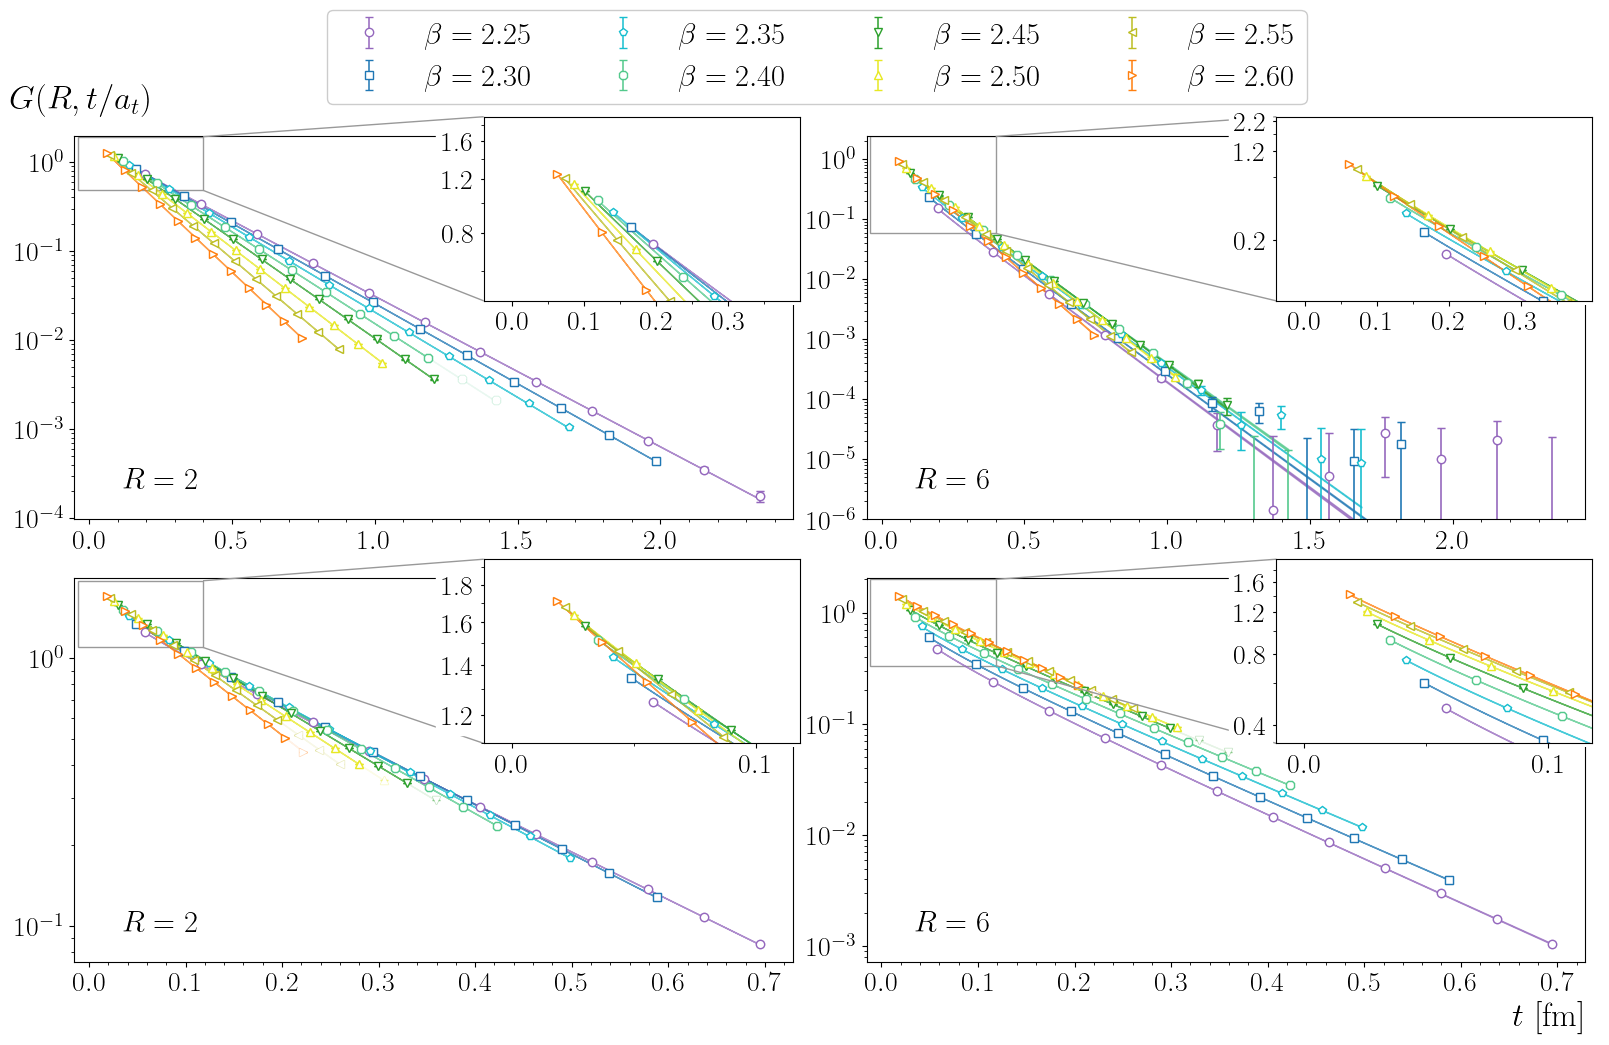

In [5]:
betarun  = beta[fileini:filefin+1][0:8]
xirun=xi[xiini:xifin+1]


plot_pars=[[[0,1],[0,5]],[[3,1],[3,5]]]

pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001

mpl.rcParams['axes.autolimit_mode'] = 'data'
mpl.rcParams['axes.xmargin'] = 0.05
mpl.rcParams['axes.ymargin'] = 0.05

fig, ax = plt.subplots(2,2,figsize=(16,9))
fig.tight_layout()


ax[1][1].set_xlabel("$t$ [fm]",fontsize = 24,loc='right')
ax[0][0].set_ylabel("$G(R,t/a_t)$", rotation=0,fontsize = 24)
ax[0][0].yaxis.set_label_coords(0.01,1.05)

for xind in range(len(plot_pars)):
    for rind in range(len(plot_pars[0])):
        x=plot_pars[xind][rind][0]
        r=plot_pars[xind][rind][1]
        bbox_axins=np.array([0.57,0.57,0.44,0.48])
        axins = inset_axes(ax[xind][rind],width="100%",height="100%",loc='center',bbox_to_anchor=(bbox_axins),bbox_transform=ax[xind][rind].transAxes)
        mark_inset_mod(ax[xind][rind], axins, loc1a=2, loc2a=3, loc1b=1, loc2b=4, fc="none", ec="0.6")
        x_vals=[]
        y_vals=[]
        for k in range(len(betarun)):
            with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
                AIC_list = pickle.load(fp)
                

            xival=x+1
            totaltraj=int(len(data[x][k])/size[k])
            Nt=Textent

            Gc=np.zeros((int(totaltraj/jump_configs),Nt))
            for i in range(int(totaltraj/jump_configs)):
                index=jump_configs*i
                Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]


            gdata=jackknife(Gc,jackkl).sample()
            lt=len(Gc[0])
            dfin=min(lt,100)
            data_t   = np.linspace(1, lt, lt)
            data_2t  = np.linspace(1, 2*lt-1, 2*lt-1)
            if pos==0:
                data_y   = ensemble_stat(gdata).mean()
            else:
                data_y   = gdata[pos]
            data_cov = ensemble_stat(jackknife(gdata,jackkl).up()).rcov()
            data_err = np.sqrt(np.diagonal(ensemble_stat(jackknife(gdata,jackkl).up()).rcov()))


            data_covf = np.identity(lt)
            for i in range(len(np.sqrt(np.diag(data_cov)))):
                for j in range(len(np.sqrt(np.diag(data_cov)))):
                    data_covf[i][j]*=np.sqrt(np.diag(data_cov))[i]*np.sqrt(np.diag(data_cov))[j]

            data_t_plot=np.linspace(data_t[0],data_t[-1],1000)

            tmin=AIC_list.ordered()[0][1]
            tmax=AIC_list.ordered()[0][2]

            bf_data_t=data_t[tmin-1:tmax-tmin+1]
            bf_data_y=data_y[tmin-1:tmax-tmin+1]
            bf_data_err=data_err[tmin-1:tmax-tmin+1]
            bf_data_t_plot=np.linspace(bf_data_t[0],bf_data_t[-1],1000)

            pars=np.array(AIC_list.selval()[0][1:])
            epars=np.array(AIC_list.selval()[1][1:])
            cpars=np.array(AIC_list.selval()[2][1:,1:])

            fit     = eval(model_Gc)(data_t_plot,*pars)
            efit    = prop_err(data_t_plot,model_Gc,pars,epars,cpars)
            fits    = eval(model_Gc)(bf_data_t_plot,*pars)
            efits   = prop_err(bf_data_t_plot,model_Gc,pars,epars,cpars)

            ax[xind][rind].fill_between(data_t_plot*als[x][k]/xival, fit+efit, fit-efit,color=jpac_color_around[k],alpha=0.1)
            ax[xind][rind].fill_between(bf_data_t_plot*als[x][k]/xival, fits+efits, fits-efits,color=jpac_color_around[k],alpha=0.7)

            ax[xind][rind].errorbar(data_t*als[x][k]/xival, data_y, data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white', alpha=0.3)
            ax[xind][rind].errorbar(data_t*als[x][k]/xival, data_y, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white',markeredgecolor='none', alpha=1.)
            if (xind==0 and rind==0):
                ax[xind][rind].errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[k], label='$\\beta={:.2f}$'.format(betarun[k]/betanorm), color=jpac_color_around[k],markerfacecolor='white')
            else:
                ax[xind][rind].errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white')

            axins.errorbar(data_t*als[x][k]/xival, data_y, data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white', alpha=0.3)
            axins.errorbar(data_t*als[x][k]/xival, data_y, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white',markeredgecolor='none', alpha=1.)
            axins.errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white')
            axins.fill_between(data_t_plot*als[x][k]/xival, fit+efit, fit-efit,color=jpac_color_around[k],alpha=0.1)
            axins.fill_between(bf_data_t_plot*als[x][k]/xival, fits+efits, fits-efits,color=jpac_color_around[k],alpha=0.7)
    
            x_vals.append(data_t[0]*als[x][k]/xival)
            y_vals.append(data_y[0])

        x_vals=np.array(x_vals)
        y_vals=np.array(y_vals)

        ax[xind][rind].set_yscale('log')
        ax[xind][rind].autoscale(enable='True',axis='both')
        ax[xind][rind].axis('tight')
        
        if (ax[xind][rind].get_ylim()[0]<0.000001):
            ax[xind][rind].set_ylim(0.000001)

        diffx=ax[xind][rind].get_xlim()[1]-ax[xind][rind].get_xlim()[0]
        diffy=ax[xind][rind].get_ylim()[1]-ax[xind][rind].get_ylim()[0]
        xini=ax[xind][rind].get_xlim()[0]+0.005*diffx
        xfin=np.max(x_vals)+2.*np.min(x_vals-xini)
        yfin=(0.98)*ax[xind][rind].get_ylim()[1]
        yminlog=np.min(np.log(y_vals))-1.*np.min(np.log(yfin)-np.log(y_vals))
        yini=max(np.exp(yminlog),0.0001)

        axins.set_yscale('log')
        axins.set_xlim(xini,xfin)
        axins.set_ylim(yini,yfin)
        x_major_list=np.arange(0,100)/10
        x_minor_list=np.arange(0,100)/20

        axins.minorticks_off()
        axins.xaxis.set_minor_locator(ticker.FixedLocator((x_minor_list)))
        axins.xaxis.set_major_locator(ticker.FixedLocator((x_major_list)))

        if (yfin-yini>2):
            y_list=np.arange(0,100)+0.2
            y_list_minor=np.arange(0,100)+0.2+0.5
        elif (yfin-yini>1):
            y_list=np.arange(0,100)*0.4
            y_list_minor=np.arange(0,100)*0.2
        else:
            y_list=np.arange(0,100)*0.2
            y_list_minor=np.arange(0,100)*0.1

        axins.yaxis.set_major_locator(ticker.FixedLocator((y_list)))
        axins.yaxis.set_minor_locator(ticker.FixedLocator((y_list_minor)))
        axins.yaxis.set_minor_formatter(NullFormatter())
        #axins.yaxis.set_major_formatter(NullFormatter())
        axins.set_yticklabels(axins.get_yticks().round(decimals=1), backgroundcolor='w')
        #axins.set_xticklabels(axins.get_xticks().round(decimals=1), backgroundcolor='w')
        
        ax[xind][rind].axes.text(0.12, 0.1, 
        '$R={}$'.format(r+1), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 22,  
        color ="black",transform=ax[xind][rind].transAxes)

        coords = ax[xind][rind].transAxes.inverted().transform(axins.get_tightbbox())
        border = 0.01
        position_patch=bbox_axins[:2]
        ax[xind][rind].add_patch(plt.Rectangle(position_patch-border, bbox_axins[2]+2*border, bbox_axins[3]+2*border, fc="w", 
        transform=ax[xind][rind].transAxes, zorder=100,clip_on=False))

fig.legend(fontsize=22,frameon=True,loc='upper center',ncols=4,fancybox=True,shadow=False,framealpha=1,bbox_to_anchor=(0.5, 1.13))
fig.show()
fig.savefig('../../final_plots/final_{}_{}_GRT_L={}_combined_logplot_ti{}_{}_tfin{}_tmin{}_nocorrs={}_{}.pdf'.format(len(variants_Gc),model_Gc,sizelabel,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)

In [9]:
with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
    AIC_list = pickle.load(fp)

In [ ]:
if (yfin-yini>2):
            y_list=np.arange(0,100)+0.2
            y_list_minor=np.arange(0,100)+0.2+0.5
        elif (yfin-yini>1):
            y_list=np.arange(0,100)*0.4
            y_list_minor=np.arange(0,100)*0.2
        else:
            y_list=np.arange(0,100)*0.2
            y_list_minor=np.arange(0,100)*0.1

In [ ]:
y_list=np.arange(0,100)*0.2
y_list_minor=np.arange(0,100)*0.1

(y_list_minor-y_list)

In [ ]:
betarun  = beta[fileini:filefin+1][0:8]
xirun=xi[xiini:xifin+1]


plot_pars=[[[0,0],[0,5]],[[3,0],[3,5]]]

pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001

mpl.rcParams['axes.autolimit_mode'] = 'data'
mpl.rcParams['axes.xmargin'] = 0.05
mpl.rcParams['axes.ymargin'] = 0.05

fig, ax = plt.subplots(2,2,figsize=(16,9))
fig.tight_layout()

for xind in range(len(plot_pars)):
    for rind in range(len(plot_pars[0])):
        x=plot_pars[xind][rind][0]
        r=plot_pars[xind][rind][1]
        axins = inset_axes(ax[xind][rind],width="100%",height="100%",loc='center',bbox_to_anchor=(0.5,0.5,0.53,0.55),bbox_transform=ax[xind][rind].transAxes)
        mark_inset_mod(ax[xind][rind], axins, loc1a=2, loc2a=3, loc1b=1, loc2b=4, fc="none", ec="0.6")
        x_vals=[]
        y_vals=[]
        for k in range(len(betarun)):
            with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
                AIC_list = pickle.load(fp)


            xival=x+1
            totaltraj=int(len(data[x][k])/size[k])
            Nt=Textent

            Gc=np.zeros((int(totaltraj/jump_configs),Nt))
            for i in range(int(totaltraj/jump_configs)):
                index=jump_configs*i
                Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]


            gdata=jackknife(Gc,jackkl).sample()
            lt=len(Gc[0])
            dfin=min(lt,100)
            data_t   = np.linspace(1, lt, lt)
            data_2t  = np.linspace(1, 2*lt-1, 2*lt-1)
            if pos==0:
                data_y   = ensemble_stat(gdata).mean()
            else:
                data_y   = gdata[pos]
            data_cov = ensemble_stat(jackknife(gdata,jackkl).up()).rcov()
            data_err = np.sqrt(np.diagonal(ensemble_stat(jackknife(gdata,jackkl).up()).rcov()))


            data_covf = np.identity(lt)
            for i in range(len(np.sqrt(np.diag(data_cov)))):
                for j in range(len(np.sqrt(np.diag(data_cov)))):
                    data_covf[i][j]*=np.sqrt(np.diag(data_cov))[i]*np.sqrt(np.diag(data_cov))[j]


            data_t_plot=np.linspace(data_t[0],data_t[-1],1000)

            tmin=AIC_list.ordered()[0][1]
            tmax=AIC_list.ordered()[0][2]

            bf_data_t=data_t[tmin-1:tmax-tmin+1]
            bf_data_y=data_y[tmin-1:tmax-tmin+1]
            bf_data_err=data_err[tmin-1:tmax-tmin+1]
            bf_data_t_plot=np.linspace(bf_data_t[0],bf_data_t[-1],1000)

            pars=np.array(AIC_list.selval()[0][1:])
            epars=np.array(AIC_list.selval()[1][1:])
            cpars=np.array(AIC_list.selval()[2][1:,1:])

            fit     = eval(model_Gc)(data_t_plot,*pars)
            efit    = prop_err(data_t_plot,model_Gc,pars,epars,cpars)
            fits    = eval(model_Gc)(bf_data_t_plot,*pars)
            efits   = prop_err(bf_data_t_plot,model_Gc,pars,epars,cpars)

            ax[xind][rind].errorbar(data_t*als[x][k]/xival, data_y, data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white', alpha=0.3)
            ax[xind][rind].errorbar(data_t*als[x][k]/xival, data_y, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white',markeredgecolor='none', alpha=1.)
            if (xind==0 and rind==0):
                ax[xind][rind].errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[k], label='$\\beta={:.2f}$'.format(betarun[k]/betanorm), color=jpac_color_around[k],markerfacecolor='white')
            else:
                ax[xind][rind].errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white')

            ax[xind][rind].fill_between(data_t_plot*als[x][k]/xival, fit+efit, fit-efit,color=jpac_color_around[k],alpha=0.1)
            ax[xind][rind].fill_between(bf_data_t_plot*als[x][k]/xival, fits+efits, fits-efits,color=jpac_color_around[k],alpha=0.7)

            axins.errorbar(data_t*als[x][k]/xival, data_y, data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white', alpha=0.3)
            axins.errorbar(data_t*als[x][k]/xival, data_y, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white',markeredgecolor='none', alpha=1.)
            axins.errorbar(bf_data_t*als[x][k]/xival, bf_data_y, bf_data_err, fmt=markerlist[k], color=jpac_color_around[k],markerfacecolor='white')
            axins.fill_between(data_t_plot*als[x][k]/xival, fit+efit, fit-efit,color=jpac_color_around[k],alpha=0.1)
            axins.fill_between(bf_data_t_plot*als[x][k]/xival, fits+efits, fits-efits,color=jpac_color_around[k],alpha=0.7)
    
            x_vals.append(data_t[0]*als[x][k]/xival)
            y_vals.append(data_y[0])

        x_vals=np.array(x_vals)
        y_vals=np.array(y_vals)

        ax[xind][rind].autoscale(enable='True',axis='both')
        ax[xind][rind].axis('tight')
        
        diffx=ax[xind][rind].get_xlim()[1]-ax[xind][rind].get_xlim()[0]
        diffy=ax[xind][rind].get_ylim()[1]-ax[xind][rind].get_ylim()[0]
        xini=ax[xind][rind].get_xlim()[0]+0.005*diffx
        xfin=np.max(x_vals)+2*np.min(x_vals-xini)
        yfin=(0.995)*ax[xind][rind].get_ylim()[1]
        yini=np.min(y_vals)-2*np.min(yfin-y_vals)

        axins.set_xlim(xini,xfin)
        axins.set_ylim(yini,yfin)
        axins.yaxis.set_major_locator(ticker.MaxNLocator(2))
        axins.xaxis.set_major_locator(ticker.MaxNLocator(2))

        ax[xind][rind].axes.text(0.32, 0.85, 
        '$R={}$'.format(r+1), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 22,  
        color ="black",transform=ax[xind][rind].transAxes)
        
        #plt.xticks(fontsize=32)
        #plt.yticks(fontsize=32)

fig.legend(fontsize=22,frameon=True,loc='upper center',ncols=4,fancybox=True,shadow=False,framealpha=1,bbox_to_anchor=(0.5, 1.13))

ax[1][1].set_xlabel("$t$ [fm]",fontsize = 24,loc='right')
ax[0][0].set_ylabel("$G(R,t/a_t)$", rotation=0,fontsize = 24)

ax[0][0].yaxis.set_label_coords(0.01,1.05)

fig.show()
fig.savefig('../../final_plots/final_{}_{}_GRT_L={}_combined_ti{}_{}_tfin{}_tmin{}_nocorrs={}_{}.pdf'.format(len(variants_Gc),model_Gc,sizelabel,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)

In [ ]:
k=6
with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
        AIC_list = pickle.load(fp)

In [ ]:
AIC_list.ordered()[1]

In [ ]:
betarun  = beta[fileini:filefin+1][0:8]
xirun=xi[xiini:xifin+1]

x=3
xival=x+1
r=0
pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001

data_x     = []
pole_term  = []
epole_term = []
plt.figure(figsize=(16,9))
for k in range(len(betarun)):
    with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
        AIC_list = pickle.load(fp)

    norm=als[x][k]/xival
    data_x.append(beta[k])
    pole_term.append(AIC_list.avgval0(cutoff_ma,2)[0][0]*norm)
    epole_term.append(AIC_list.avgval0(cutoff_ma,2)[1][0]*norm)

#plt.yscale('log')
plt.errorbar(data_x, pole_term, epole_term, fmt=markerlist[0], color=jpac_red,markerfacecolor='white', alpha=1.)
plt.xlabel("$\\beta$")

In [ ]:
k=0
with open('../{}/xi={}/{}_{}_{}_AIC_list_ti{}_{}_tfin{}_tmin{}_beta={}_R={}_nocorrs={}_{}'.format(Gcplotsdir,xirun[x],len(inipars_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc, size[k], dmindata_Gc,beta[k],r+1,no_corrs,corrtype), "rb") as fp:   # Unpickling
    AIC_list = pickle.load(fp)

AIC_list.ordered()[2]